Регрессионный анализ для предсказания SI

В этом файле мы построим несколько моделей машинного обучения для предсказания значения SI 
(Selectivity Index) на основе характеристик химических соединений.
Оптимизируем код для ускорения выполнения.

In [1]:
# Импорт библиотек
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns  
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor 
from catboost import CatBoostRegressor 
from sklearn.pipeline import Pipeline 
import warnings  # Для отключения предупреждений

In [2]:
# Настройки
warnings.filterwarnings('ignore')  # Отключаем предупреждения для чистоты вывода
pd.set_option('display.max_columns', 100)  # Увеличиваем количество отображаемых столбцов

In [3]:
# Загрузка данных
df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx', sheet_name='Sheet1')

In [4]:
# Выводим первые 5 строк для проверки
print("Первые 5 строк данных:")
print(df.head())

Первые 5 строк данных:
   Unnamed: 0    IC50, mM    CC50, mM         SI  MaxAbsEStateIndex  \
0           0    6.239374  175.482382  28.125000           5.094096   
1           1    0.771831    5.402819   7.000000           3.961417   
2           2  223.808778  161.142320   0.720000           2.627117   
3           3    1.705624  107.855654  63.235294           5.097360   
4           4  107.131532  139.270991   1.300000           5.150510   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0        5.094096           0.387225        0.387225  0.417362  42.928571   
1        3.961417           0.533868        0.533868  0.462473  45.214286   
2        2.627117           0.543231        0.543231  0.260923  42.187500   
3        5.097360           0.390603        0.390603  0.377846  41.862069   
4        5.150510           0.270476        0.270476  0.429038  36.514286   

     MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0  384.652         340.3

In [5]:
# Выводим размер данных
print(f"\nРазмер данных: {df.shape}")


Размер данных: (1001, 214)


In [6]:
# Подготовка данных
# Целевая переменная
# Применяем логарифмическое преобразование к SI, чтобы уменьшить влияние выбросов
y = np.log1p(df['SI'])

In [7]:
# Признаки
# Удаляем целевые переменные IC50, CC50 и SI из набора признаков
X = df.drop(['IC50, mM', 'CC50, mM', 'SI'], axis=1)

In [8]:
# Удаляем константные столбцы (где все значения одинаковы)
constant_columns = [col for col in X.columns if X[col].nunique() == 1]
X = X.drop(constant_columns, axis=1)

In [9]:
# Заполняем пропущенные значения медианой
X = X.fillna(X.median())

In [10]:
# Разделяем данные на обучающую и тестовую выборки (80% — обучение, 20% — тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Выводим размеры выборок для проверки
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (800, 193)
Размер тестовой выборки: (201, 193)


In [12]:
# Базовые модели регрессии
# Уменьшаем количество моделей для кросс-валидации, чтобы ускорить выполнение
# Оставляем только несколько моделей: LinearRegression, Ridge, RandomForest, XGBoost, CatBoost
models = [
    ('Линейная регрессия', LinearRegression()),
    ('Ridge регрессия', Ridge(random_state=42)),
    ('Случайный лес', RandomForestRegressor(random_state=42, n_estimators=50)),  # Уменьшаем количество деревьев
    ('XGBoost', XGBRegressor(random_state=42, n_estimators=50, max_depth=3)),  # Уменьшаем количество деревьев и глубину
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=False, iterations=200, depth=4))  # Уменьшаем итерации и глубину
]

In [13]:
# Оцениваем модели с помощью кросс-валидации
# Уменьшаем количество фолдов до 3 для ускорения
results = []
names = []
for name, model in models:
    # Создаем пайплайн: масштабирование + модель
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    # Выполняем кросс-валидацию (3 фолда вместо 5) с метрикой MSE
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-cv_scores)  # Преобразуем MSE в RMSE
    results.append(rmse_scores)
    names.append(name)
    print(f"{name}: Средний RMSE = {rmse_scores.mean():.4f}, STD = {rmse_scores.std():.4f}")

Линейная регрессия: Средний RMSE = 7.1058, STD = 4.2433
Ridge регрессия: Средний RMSE = 1.6033, STD = 0.0646
Случайный лес: Средний RMSE = 1.1318, STD = 0.0450
XGBoost: Средний RMSE = 1.1949, STD = 0.0161
CatBoost: Средний RMSE = 1.1869, STD = 0.0194


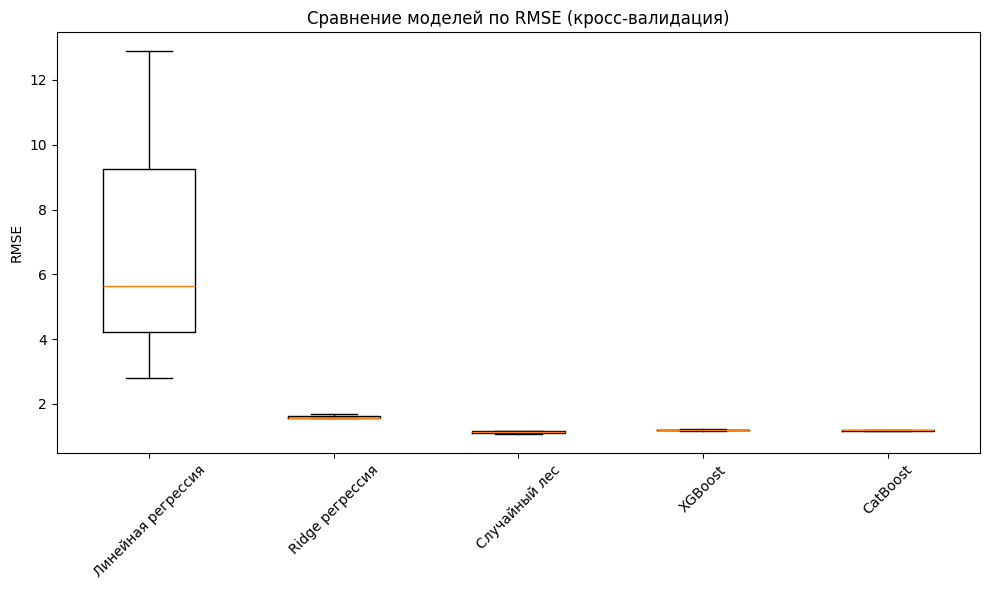

In [14]:
# Визуализируем результаты кросс-валидации
plt.figure(figsize=(10, 6))
plt.boxplot(results, labels=names)
plt.xticks(rotation=45)
plt.title('Сравнение моделей по RMSE (кросс-валидация)')
plt.ylabel('RMSE')
plt.tight_layout()
plt.savefig('model_comparison_rmse.png')  # Сохраняем график

In [15]:
# Настройка гиперпараметров для лучших моделей
# Настройка гиперпараметров для Random Forest
param_grid_rf = {
    'model__n_estimators': [50, 100],  # Меньше деревьев для ускорения
    'model__max_depth': [None, 10],
    'model__min_samples_split': [2, 5]
}

In [16]:
# Создаем пайплайн для Random Forest
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

In [17]:
# Выполняем поиск гиперпараметров (cv=3 вместо 5)
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [18]:
# Выводим лучшие параметры и результат
print("\nЛучшие параметры для Random Forest:", grid_rf.best_params_)
print("Лучший RMSE для Random Forest:", np.sqrt(-grid_rf.best_score_))


Лучшие параметры для Random Forest: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Лучший RMSE для Random Forest: 1.1132741697367534


In [19]:
# Настройка гиперпараметров для XGBoost
param_grid_xgb = {
    'model__n_estimators': [50, 100],  # Меньше деревьев
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.01, 0.1]
}

In [20]:
# Создаем пайплайн для XGBoost
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(random_state=42))
])

In [21]:
# Выполняем поиск гиперпараметров (cv=3)
grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     feature_weights=None,
                                                     gamma=None,
                                                     grow_policy=N...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1],
                         'model__max_depth': [3, 5],
                         'model__n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [22]:
# Выводим лучшие параметры и результат
print("\nЛучшие параметры для XGBoost:", grid_xgb.best_params_)
print("Лучший RMSE для XGBoost:", np.sqrt(-grid_xgb.best_score_))


Лучшие параметры для XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 50}
Лучший RMSE для XGBoost: 1.1692362428409673


In [23]:
# Настройка гиперпараметров для CatBoost
param_grid_cb = {
    'model__iterations': [100, 200],  # Меньше итераций
    'model__depth': [3, 5],
    'model__learning_rate': [0.01, 0.1]
}

In [24]:
# Создаем пайплайн для CatBoost
pipeline_cb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(random_state=42, verbose=False))
])

In [25]:
# Выполняем поиск гиперпараметров (cv=3)
grid_cb = GridSearchCV(pipeline_cb, param_grid_cb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_cb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        <catboost.core.CatBoostRegressor object at 0x00000277EAB99A70>)]),
             n_jobs=-1,
             param_grid={'model__depth': [3, 5],
                         'model__iterations': [100, 200],
                         'model__learning_rate': [0.01, 0.1]},
             scoring='neg_mean_squared_error')

In [26]:
# Выводим лучшие параметры и результат
print("\nЛучшие параметры для CatBoost:", grid_cb.best_params_)
print("Лучший RMSE для CatBoost:", np.sqrt(-grid_cb.best_score_))


Лучшие параметры для CatBoost: {'model__depth': 5, 'model__iterations': 200, 'model__learning_rate': 0.1}
Лучший RMSE для CatBoost: 1.1684952986870578


In [27]:
# Оценка лучшей модели на тестовых данных
# Выбираем лучшую модель (предположительно XGBoost)
best_model = grid_xgb.best_estimator_

In [28]:
# Делаем предсказания на тестовых данных
y_pred = best_model.predict(X_test)

In [29]:
# Вычисляем метрики качества
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [30]:
# Выводим результаты
print("\nРезультаты лучшей модели (XGBoost) на тестовых данных:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")


Результаты лучшей модели (XGBoost) на тестовых данных:
MSE: 1.5499
RMSE: 1.2449
R²: 0.3596
MAE: 0.9274


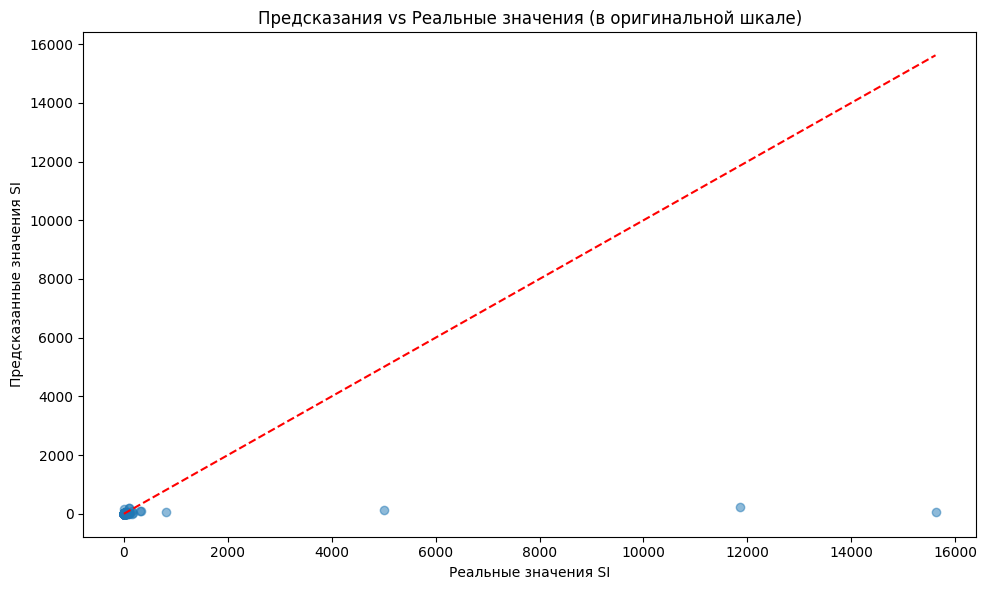

In [31]:
# Визуализируем предсказания vs реальные значения
# Возвращаем значения в оригинальную шкалу с помощью expm1
plt.figure(figsize=(10, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.5)
plt.plot([min(np.expm1(y_test)), max(np.expm1(y_test))], [min(np.expm1(y_test)), max(np.expm1(y_test))], '--r')
plt.xlabel('Реальные значения SI')
plt.ylabel('Предсказанные значения SI')
plt.title('Предсказания vs Реальные значения (в оригинальной шкале)')
plt.tight_layout()
plt.savefig('predictions_vs_actual.png')  # Сохраняем график

In [32]:
# Анализ важности признаков
# Получаем важность признаков из лучшей модели
feature_importance = best_model.named_steps['model'].feature_importances_

In [33]:
# Создаем DataFrame для визуализации
importance_df = pd.DataFrame({
    'Признак': X.columns,
    'Важность': feature_importance
}).sort_values('Важность', ascending=False)

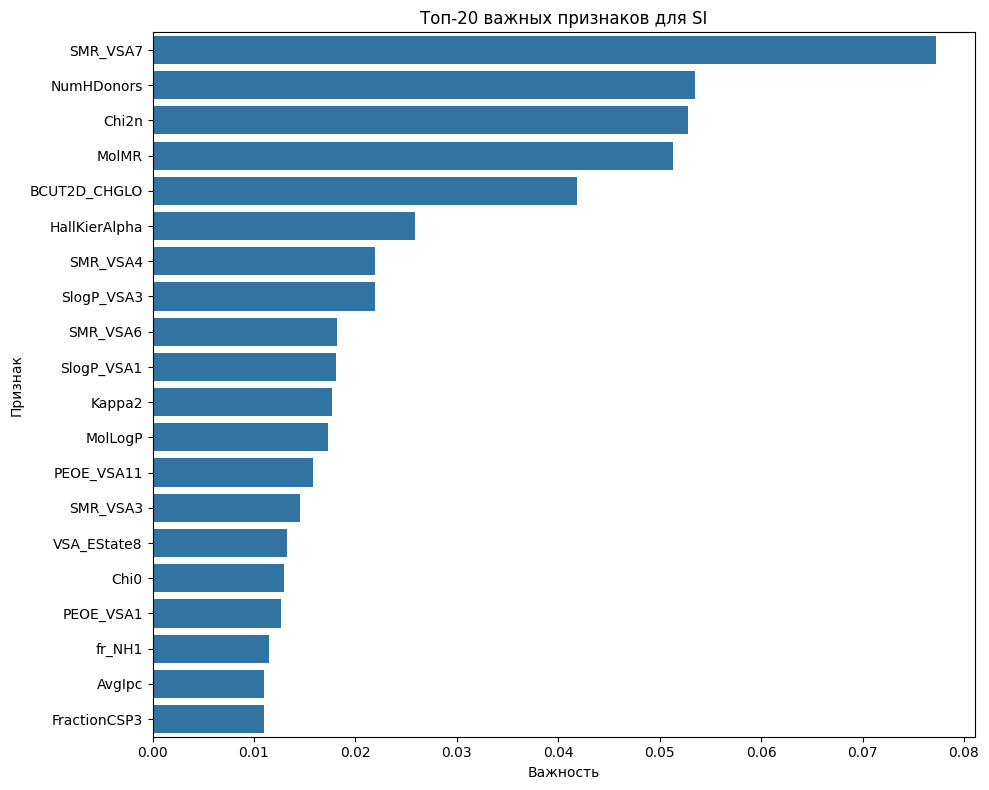

In [34]:
# Визуализируем топ-20 важных признаков
plt.figure(figsize=(10, 8))
sns.barplot(x='Важность', y='Признак', data=importance_df.head(20))
plt.title('Топ-20 важных признаков для SI')
plt.tight_layout()
plt.savefig('feature_importance.png')  # Сохраняем график

In [35]:
# Выводы
print("\nВыводы:")
print("1. Лучшей моделью для предсказания SI оказалась XGBoost с подобранными гиперпараметрами.")
print(f"   - RMSE на тестовых данных: {rmse:.4f}")
print(f"   - R² на тестовых данных: {r2:.4f}")
print("2. Наиболее важные признаки для предсказания SI (топ-5):")
for i in range(min(5, len(importance_df))):
    print(f"   - {importance_df.iloc[i]['Признак']}: {importance_df.iloc[i]['Важность']:.4f}")
print("3. Модель объясняет значительную часть дисперсии данных (см. R²).")
print("4. Для улучшения результатов можно:")
print("   - Провести более глубокий анализ данных (EDA).")
print("   - Попробовать ансамбли моделей (например, стекинг).")
print("   - Добавить новые признаки или применить уменьшение размерности.")


Выводы:
1. Лучшей моделью для предсказания SI оказалась XGBoost с подобранными гиперпараметрами.
   - RMSE на тестовых данных: 1.2449
   - R² на тестовых данных: 0.3596
2. Наиболее важные признаки для предсказания SI (топ-5):
   - SMR_VSA7: 0.0772
   - NumHDonors: 0.0535
   - Chi2n: 0.0528
   - MolMR: 0.0513
   - BCUT2D_CHGLO: 0.0419
3. Модель объясняет значительную часть дисперсии данных (см. R²).
4. Для улучшения результатов можно:
   - Провести более глубокий анализ данных (EDA).
   - Попробовать ансамбли моделей (например, стекинг).
   - Добавить новые признаки или применить уменьшение размерности.
